In [1]:
import math

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [2]:
ovid = yf.download('ovid', '2019-05-21', '2020-05-21')

[*********************100%***********************]  1 of 1 completed


In [3]:
ovid

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-21,1.72,1.76,1.695,1.72,1.72,144600
2019-05-22,1.71,1.72,1.640,1.64,1.64,239200
2019-05-23,1.61,1.67,1.600,1.65,1.65,201300
2019-05-24,1.67,1.77,1.660,1.70,1.70,198700
2019-05-28,1.71,1.73,1.600,1.61,1.61,169500
...,...,...,...,...,...,...
2020-05-14,4.20,4.34,3.990,4.11,4.11,443300
2020-05-15,4.05,4.25,3.954,4.11,4.11,517000
2020-05-18,4.18,4.35,4.120,4.17,4.17,555900


In [4]:
ovid['sma_1'] = ovid.Close.rolling(window=2).mean()
ovid['sma_7'] = ovid.Close.rolling(window=7).mean()
ovid['sma_14'] = ovid.Close.rolling(window=14).mean()
ovid['sma_30'] = ovid.Close.rolling(window=30).mean()
ovid

,Open,High,Low,Close,Adj Close,Volume,sma_1,sma_7,sma_14,sma_30
Date,,,,,,,,,,
2019-05-21,1.72,1.76,1.695,1.72,1.72,144600,NaN,NaN,NaN,NaN
2019-05-22,1.71,1.72,1.640,1.64,1.64,239200,1.680,NaN,NaN,NaN
2019-05-23,1.61,1.67,1.600,1.65,1.65,201300,1.645,NaN,NaN,NaN
2019-05-24,1.67,1.77,1.660,1.70,1.70,198700,1.675,NaN,NaN,NaN
2019-05-28,1.71,1.73,1.600,1.61,1.61,169500,1.655,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-05-14,4.20,4.34,3.990,4.11,4.11,443300,4.145,3.881429,3.742857,3.435667
2020-05-15,4.05,4.25,3.954,4.11,4.11,517000,4.110,3.942857,3.778571,3.476667
2020-05-18,4.18,4.35,4.120,4.17,4.17,555900,4.140,4.035714,3.814286,3.523333


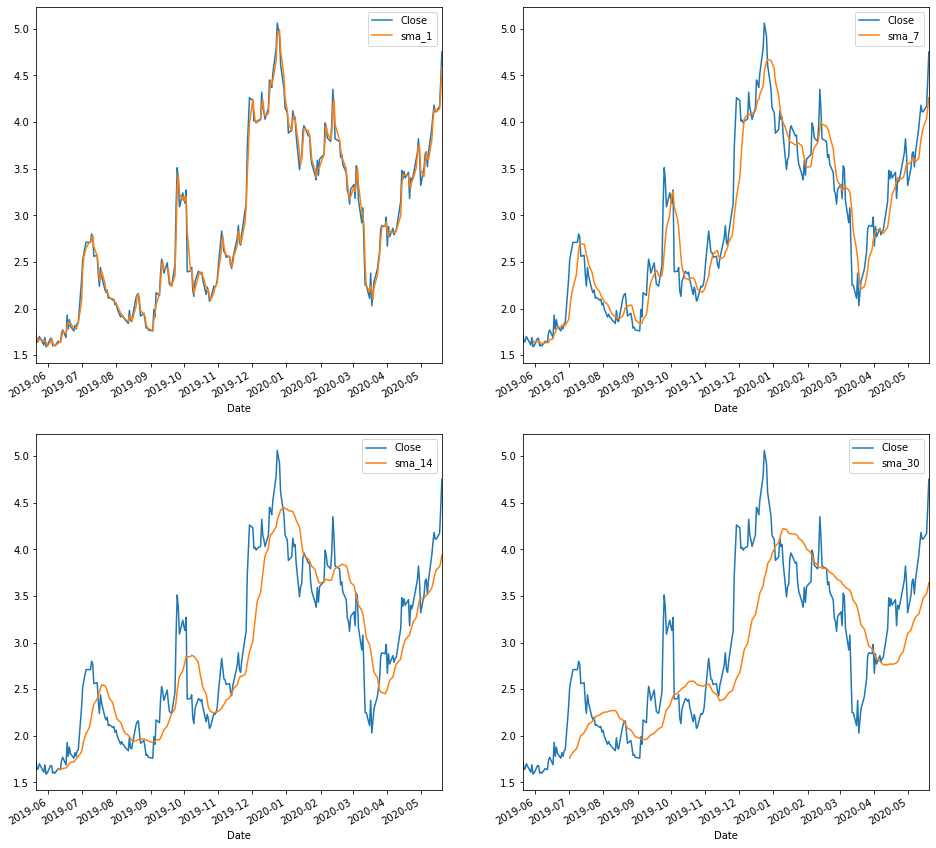

In [5]:
plt.figure(figsize=(16, 16))
plt.subplot(221)
ovid.Close.plot()
ovid.sma_1.plot()
plt.legend()
plt.subplot(222)
ovid.Close.plot()
ovid.sma_7.plot()
plt.legend()
plt.subplot(223)
ovid.Close.plot()
ovid.sma_14.plot()
plt.legend()
plt.subplot(224)
ovid.Close.plot()
ovid.sma_30.plot()
plt.legend()

In [6]:
ovid['ema_1'] = ovid.Close.ewm(span=2, adjust=False).mean()
ovid['ema_7'] = ovid.Close.ewm(span=7, adjust=False).mean()
ovid['ema_14'] = ovid.Close.ewm(span=14, adjust=False).mean()
ovid['ema_30'] = ovid.Close.ewm(span=30, adjust=False).mean()
ovid

,Open,High,Low,Close,Adj Close,Volume,sma_1,sma_7,sma_14,sma_30,ema_1,ema_7,ema_14,ema_30
Date,,,,,,,,,,,,,,
2019-05-21,1.72,1.76,1.695,1.72,1.72,144600,NaN,NaN,NaN,NaN,1.720000,1.720000,1.720000,1.720000
2019-05-22,1.71,1.72,1.640,1.64,1.64,239200,1.680,NaN,NaN,NaN,1.666667,1.700000,1.709333,1.714839
2019-05-23,1.61,1.67,1.600,1.65,1.65,201300,1.645,NaN,NaN,NaN,1.655556,1.687500,1.701422,1.710656
2019-05-24,1.67,1.77,1.660,1.70,1.70,198700,1.675,NaN,NaN,NaN,1.685185,1.690625,1.701233,1.709968
2019-05-28,1.71,1.73,1.600,1.61,1.61,169500,1.655,NaN,NaN,NaN,1.635062,1.670469,1.689068,1.703519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-14,4.20,4.34,3.990,4.11,4.11,443300,4.145,3.881429,3.742857,3.435667,4.112530,3.935978,3.764437,3.523256
2020-05-15,4.05,4.25,3.954,4.11,4.11,517000,4.110,3.942857,3.778571,3.476667,4.110843,3.979484,3.810512,3.561110
2020-05-18,4.18,4.35,4.120,4.17,4.17,555900,4.140,4.035714,3.814286,3.523333,4.150281,4.027113,3.858444,3.600394


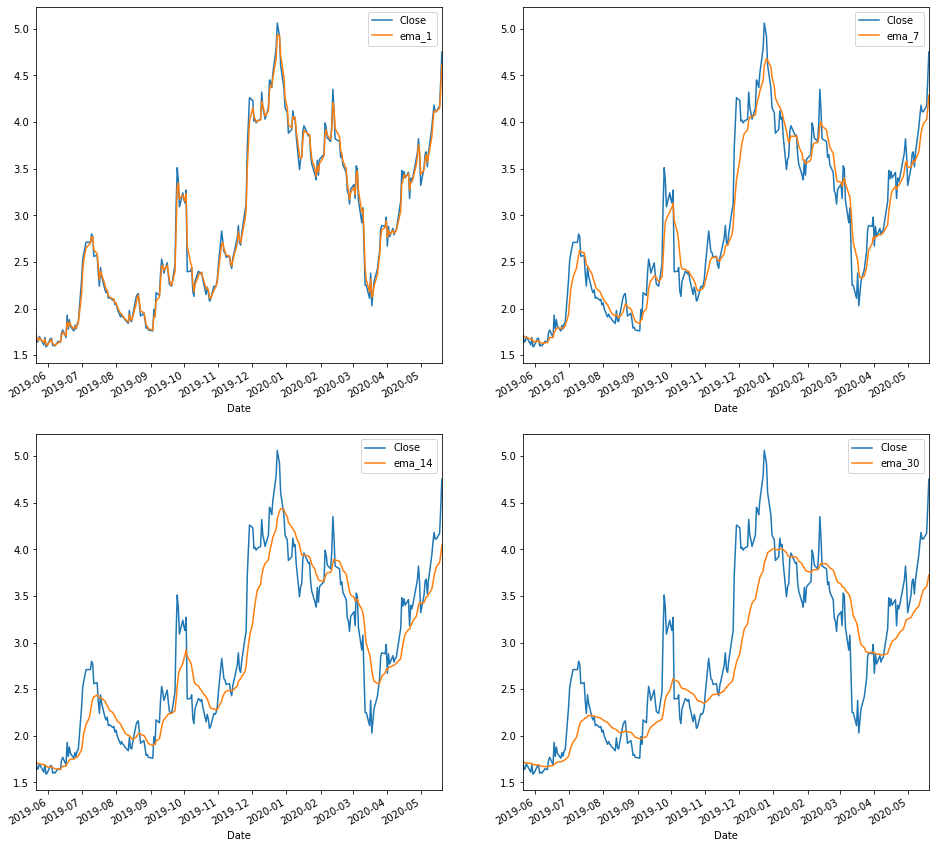

In [7]:
plt.figure(figsize=(16, 16))
plt.subplot(221)
ovid.Close.plot()
ovid.ema_1.plot()
plt.legend()
plt.subplot(222)
ovid.Close.plot()
ovid.ema_7.plot()
plt.legend()
plt.subplot(223)
ovid.Close.plot()
ovid.ema_14.plot()
plt.legend()
plt.subplot(224)
ovid.Close.plot()
ovid.ema_30.plot()
plt.legend()

In [8]:
train = ovid[:'2020-04'][['Close']]
test = ovid['2020-05':][['Close']]

In [9]:
train

,Close
Date,
2019-05-21,1.72
2019-05-22,1.64
2019-05-23,1.65
2019-05-24,1.70
2019-05-28,1.61
...,...
2020-04-24,3.41
2020-04-27,3.61
2020-04-28,3.67


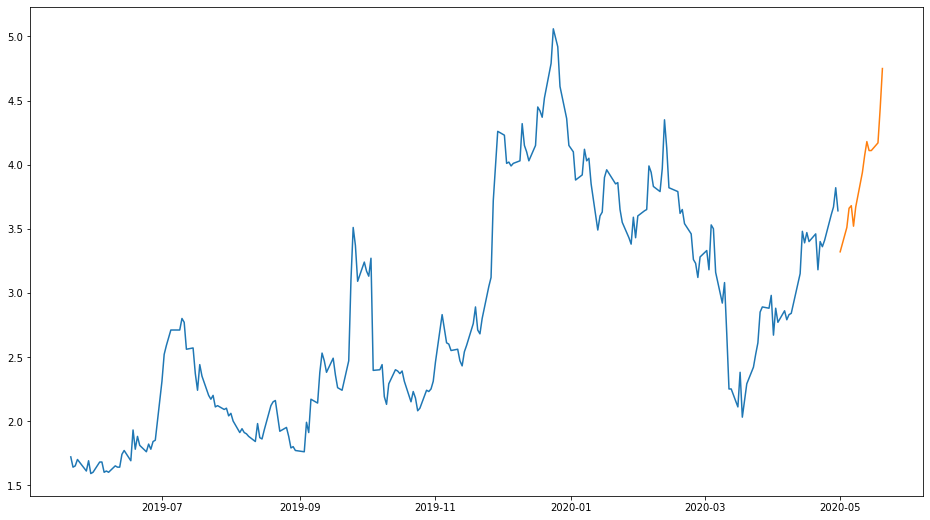

In [10]:
plt.figure(figsize=(16,9))
plt.plot(train)
plt.plot(test)

In [11]:
def get_rmse(model):
    return round(math.sqrt(mean_squared_error(test.Close, test[model])), 2)

## Last observed value

In [12]:
test['lov'] = round(train.Close[-1:][0], 2)

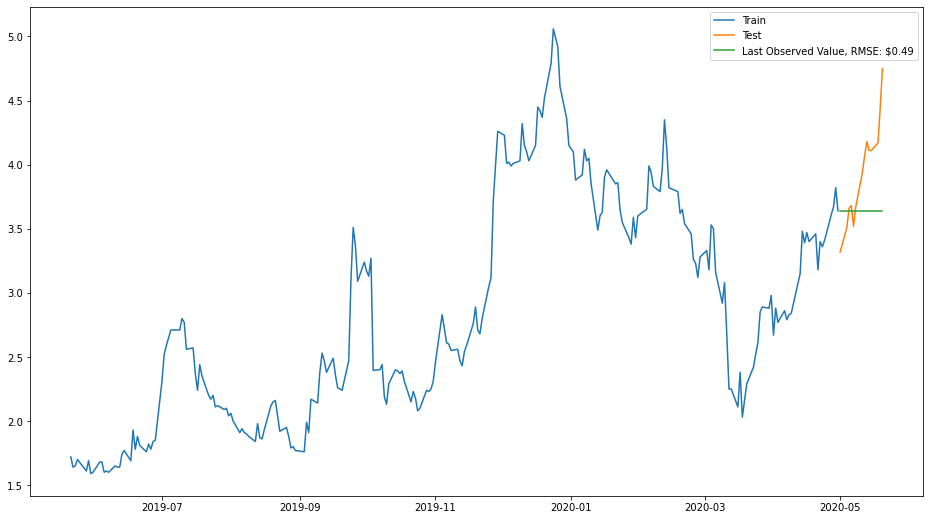

In [13]:
plt.figure(figsize=(16,9))
plt.plot(train, label='Train')
plt.plot(test.Close, label='Test')
plt.plot(test.lov, label=f'Last Observed Value, RMSE: ${get_rmse("lov")}')
plt.legend()

# Simple Average

In [14]:
test['sa'] = round(train.Close.mean(), 2)

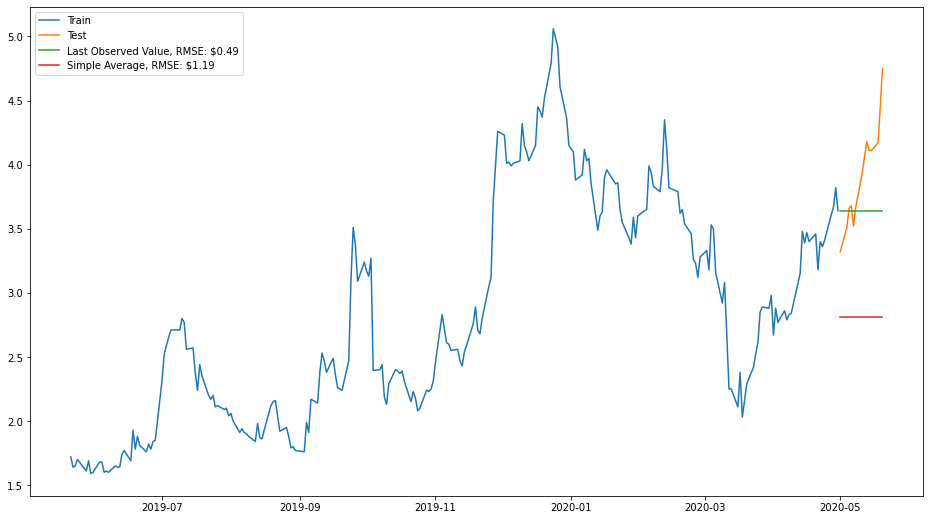

In [15]:
plt.figure(figsize=(16,9))
plt.plot(train, label='Train')
plt.plot(test.Close, label='Test')
plt.plot(test.lov, label=f'Last Observed Value, RMSE: ${get_rmse("lov")}')
plt.plot(test.sa, label=f'Simple Average, RMSE: ${get_rmse("sa")}')
plt.legend()

## Moving Average

In [16]:
test['weekly_ma'] = round(train.Close.rolling(7).mean().iloc[-1], 2)
test['monthly_ma'] = round(train.Close.rolling(30).mean().iloc[-1], 2)

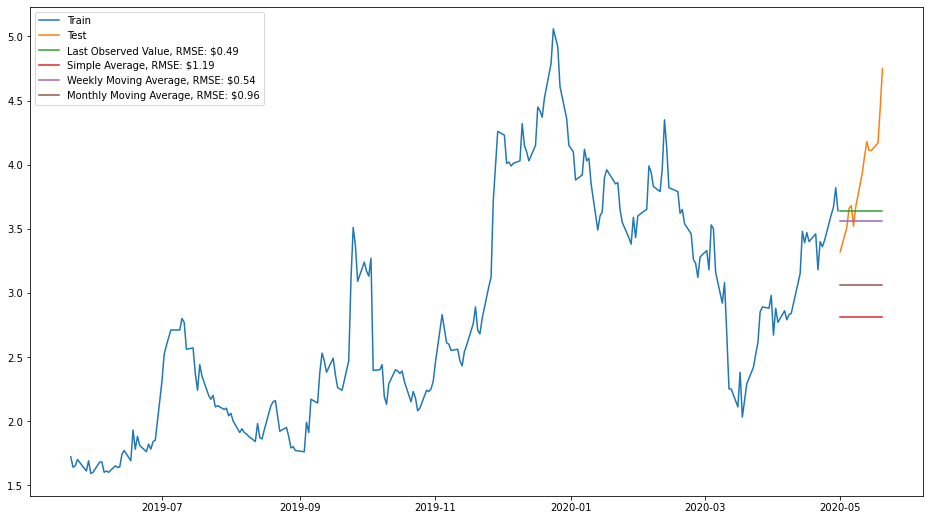

In [17]:
plt.figure(figsize=(16,9))
plt.plot(train, label='Train')
plt.plot(test.Close, label='Test')
plt.plot(test.lov, label=f'Last Observed Value, RMSE: ${get_rmse("lov")}')
plt.plot(test.sa, label=f'Simple Average, RMSE: ${get_rmse("sa")}')
plt.plot(test.weekly_ma, label=f'Weekly Moving Average, RMSE: ${get_rmse("weekly_ma")}')
plt.plot(test.monthly_ma, label=f'Monthly Moving Average, RMSE: ${get_rmse("monthly_ma")}')
plt.legend()

## Previous Cycle

In [18]:
preds = train.iloc[-(len(test)):] + train.diff(len(test)).mean()

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [19]:
pd.concat([preds.head(1), test.head(1)])

,Close,lov,monthly_ma,sa,weekly_ma
Date,,,,,
2020-04-13,3.262978,NaN,NaN,NaN,NaN
2020-05-01,3.320000,3.64,3.06,2.81,3.56


In [20]:
preds.index = test.index

In [21]:
test['last_monthly_cycle'] = round(preds, 2)

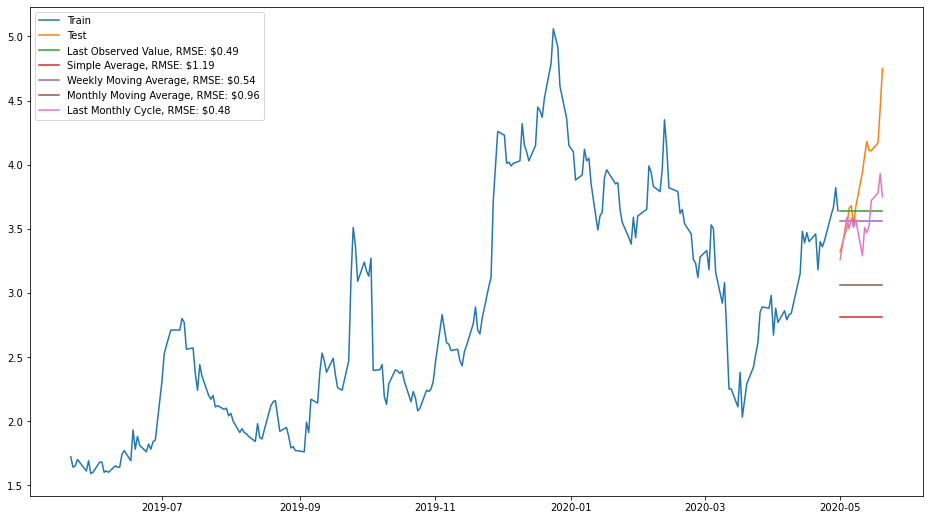

In [22]:
plt.figure(figsize=(16,9))
plt.plot(train, label='Train')
plt.plot(test.Close, label='Test')
plt.plot(test.lov, label=f'Last Observed Value, RMSE: ${get_rmse("lov")}')
plt.plot(test.sa, label=f'Simple Average, RMSE: ${get_rmse("sa")}')
plt.plot(test.weekly_ma, label=f'Weekly Moving Average, RMSE: ${get_rmse("weekly_ma")}')
plt.plot(test.monthly_ma, label=f'Monthly Moving Average, RMSE: ${get_rmse("monthly_ma")}')
plt.plot(test.last_monthly_cycle, label=f'Last Monthly Cycle, RMSE: ${get_rmse("last_monthly_cycle")}')
plt.legend()

## Prophet

In [23]:
train = train.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
train

,ds,y
0,2019-05-21,1.72
1,2019-05-22,1.64
2,2019-05-23,1.65
3,2019-05-24,1.70
4,2019-05-28,1.61
...,...,...
234,2020-04-24,3.41
235,2020-04-27,3.61
236,2020-04-28,3.67
237,2020-04-29,3.82


In [24]:
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
future = model.make_future_dataframe(periods = 2*len(test))
future

,ds
0,2019-05-21
1,2019-05-22
2,2019-05-23
3,2019-05-24
4,2019-05-28
...,...
262,2020-05-24
263,2020-05-25
264,2020-05-26
265,2020-05-27


In [26]:
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

In [27]:
forecast = model.predict(future)

In [28]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-05-21,1.589661,0.978159,2.207108,1.589661,1.589661,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.007302,0.007302,0.007302,0.0,0.0,0.0,1.596963
1,2019-05-22,1.597636,0.915821,2.178851,1.597636,1.597636,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.031701,-0.031701,-0.031701,0.0,0.0,0.0,1.565935
2,2019-05-23,1.605610,0.923118,2.161466,1.605610,1.605610,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.032125,-0.032125,-0.032125,0.0,0.0,0.0,1.573485
3,2019-05-24,1.613585,0.951335,2.178050,1.613585,1.613585,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.053219,-0.053219,-0.053219,0.0,0.0,0.0,1.560365
4,2019-05-28,1.645482,0.966541,2.290493,1.645482,1.645482,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.007302,0.007302,0.007302,0.0,0.0,0.0,1.652785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,2020-05-22,2.928383,2.247795,3.502571,2.910464,2.944933,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.053219,-0.053219,-0.053219,0.0,0.0,0.0,2.875163
255,2020-05-25,2.911395,2.269916,3.567197,2.889016,2.932709,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.017791,-0.017791,-0.017791,0.0,0.0,0.0,2.893604
256,2020-05-26,2.905733,2.311347,3.562785,2.881526,2.928771,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.007302,0.007302,0.007302,0.0,0.0,0.0,2.913035
257,2020-05-27,2.900070,2.230448,3.499730,2.874423,2.924847,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.031701,-0.031701,-0.031701,0.0,0.0,0.0,2.868369


In [29]:
test['prophet'] = round(forecast.set_index('ds')['2020-05-01': '2020-05-20'].yhat, 2)
test

,Close,lov,sa,weekly_ma,monthly_ma,last_monthly_cycle,prophet
Date,,,,,,,
2020-05-01,3.32,3.64,2.81,3.56,3.06,3.26,2.99
2020-05-04,3.51,3.64,2.81,3.56,3.06,3.59,3.01
2020-05-05,3.66,3.64,2.81,3.56,3.06,3.50,3.03
2020-05-06,3.68,3.64,2.81,3.56,3.06,3.58,2.99
2020-05-07,3.52,3.64,2.81,3.56,3.06,3.51,2.98
2020-05-08,3.67,3.64,2.81,3.56,3.06,3.57,2.95
2020-05-11,3.94,3.64,2.81,3.56,3.06,3.29,2.97
2020-05-12,4.07,3.64,2.81,3.56,3.06,3.51,2.99
2020-05-13,4.18,3.64,2.81,3.56,3.06,3.47,2.95


In [30]:
# plt.figure(figsize=(16,9))
# plt.plot(train, label='Train')
# plt.plot(test.Close, label='Test')
# plt.plot(test.lov, label=f'Last Observed Value, RMSE: ${get_rmse("lov")}')
# plt.plot(test.sa, label=f'Simple Average, RMSE: ${get_rmse("sa")}')
# plt.plot(test.weekly_ma, label=f'Weekly Moving Average, RMSE: ${get_rmse("weekly_ma")}')
# plt.plot(test.monthly_ma, label=f'Monthly Moving Average, RMSE: ${get_rmse("monthly_ma")}')
# plt.plot(test.last_monthly_cycle, label=f'Last Monthly Cycle, RMSE: ${get_rmse("last_monthly_cycle")}')
# plt.plot(test.prophet, label=f'Last Monthly Cycle, RMSE: ${get_rmse("last_monthly_cycle")}')
# plt.legend()